## Data Cleaning and Shape Examining 


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

training_data = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
testing_data = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
descriptions = pd.read_csv('input/product_descriptions.csv.zip')

training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")


In [2]:
training_data.shape

(74067, 6)

As in the dataset page has mentioned that it might contains some embedded html tags, let's plot and see how many in percentage, more prececily the fields 'product_description'

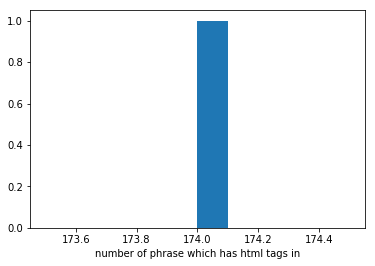

has html tags in  174
doesn't have html tags in  124254


In [3]:
%matplotlib inline
total_length = len(descriptions['product_description'] )
has_tag = sum([1 for _ in descriptions['product_description'] if '<br' in _])
no_tags = total_length - has_tag

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(x=[has_tag])
ax.ticklabel_format(useOffset=False)
_ = plt.xlabel('number of phrase which has html tags in')

plt.show()
print('has html tags in ',has_tag)
print('doesn\'t have html tags in ', no_tags)


Now let's see what is the frequency of search query which include digits in it with respect to product_title which 
includes words. As you can see most of them includes digits in search bar. 


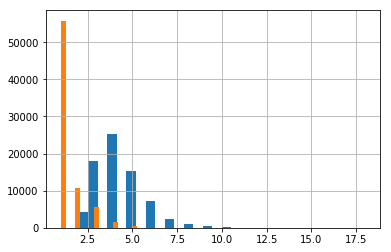

In [4]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search therms
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of digits in search terms
# (training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of digits in title






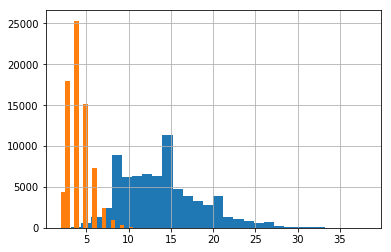

In [5]:
(training_data.product_title.str.count("\\w+") + 1).hist(bins=30)#plot number of words in title
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search query





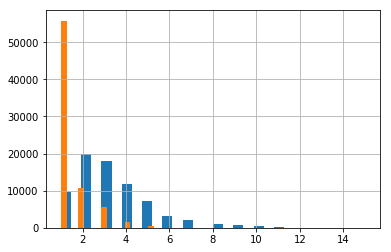

In [6]:
(training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of words in title
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of words in search query






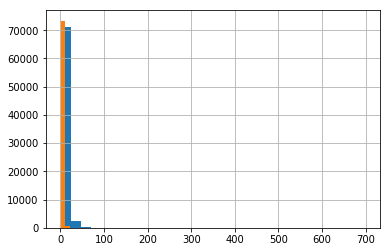

In [7]:
(training_data.product_description.str.count("\\d+") + 1).hist(bins=30)
(training_data.product_description.str.count("\\d+\W+\d+") + 1).hist(bins=30)



let's plot at histogram following number of words in search query, and on the other hand relevancy score

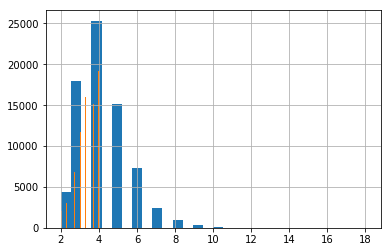

In [8]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30)
(training_data.relevance + 1).hist(bins=30)



let's take a look how does the persistence of digits in the search query influence the relevancy score, from below plot it clearly that most of the search query must have between 2.0 and 3.0 

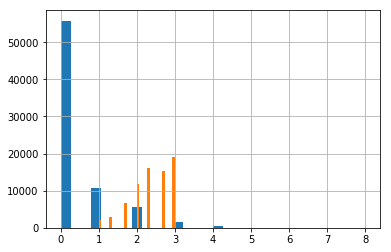

In [9]:
(training_data.search_term.str.count("\\d+")).hist(bins=30)
(training_data.relevance ).hist(bins=30)

let’s assume that there are zero response for null query search term


In [10]:
training_data[training_data.search_term.str.count('\\w+') < 1]
# training_data[training_data.search_term.str.contains('^\d+') < 1]

,id,product_uid,product_title,search_term,relevance,product_description


In [11]:
# an interest case can be see below, unfortunattly we cannot get rid of this element since it will make a bad impact on model
training_data[training_data.product_uid==100030]

,id,product_uid,product_title,search_term,relevance,product_description
44,164,100030,9.1 in. x 5.8 in. White Designer Shelf Bracket,8 4616809045 9,1.67,White Designer Shelf Brackets offer a stylish ...
45,165,100030,9.1 in. x 5.8 in. White Designer Shelf Bracket,shelf bracket,3.00,White Designer Shelf Brackets offer a stylish ...
46,166,100030,9.1 in. x 5.8 in. White Designer Shelf Bracket,white 4shelves,1.67,White Designer Shelf Brackets offer a stylish ...


In [12]:
training_data[training_data.product_description.str.contains('.* x .*')].head(4) # at first it looks like nothing unsual 


,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
9,27,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.00,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
14,48,100012,Hampton Bay Caramel Simple Weave Bamboo Rollup...,hampton bay chestnut pull up shade,2.67,The 96 in. wide Caramel Simple Weave Rollup Ba...


Unfortunately, it is kind ambiguous to figure out the meaning of digits in the search context like an example below, it can mean anything. we should take care of this when cleaning context. It looks that most of the case the meaning of X is denoted the unit of measure like fit/inch/or something by something


In [13]:
# training_data[training_data.search_term.str.contains("^\\d+ . \\d+$")].head(4)
training_data[(training_data.search_term.str.contains("^\\d+ . \\d+$") )& (training_data.relevance > 2)].head(4)

,id,product_uid,product_title,search_term,relevance,product_description
3766,11705,102041,Kaleen Habitat Calypso Azure 4 ft. x 6 ft. Ind...,4 x 6,3.00,Habitat Calypso Azure 4 ft. x 6 ft. Area Rug i...
7247,22691,104370,Wilsonart 48 in. x 96 in. Laminate Sheet in Mo...,48 x 96,2.33,Wilsonart's 48 in. x 96 in. Montana Walnut Lam...
7485,23405,104575,Yosemite Home Decor Undermount Stainless Steel...,23 x 38,2.33,These high quality Yosemite sinks are a heavy ...
13639,42190,110172,Sigman 20 ft. x 20 ft. Blue Tarp,20 x 20,2.67,All-purpose blue poly tarps are widely used fo...


In order to apply any standard method for analysis we have to standardize metric for text fields, which we define as follows

- split into tokens by white space
- remove punctuation from each token
- remove remaining tokens that are not alphabetic
- filter out stop words
- filter out short tokens

and lets also create new feature which may help to our model

In [2]:
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
import nltk



def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    whole_set = set(str1.split())
    return sum(int(str2.find(word)>=0) for word in whole_set)

 



Now let's apply those function to feature column

In [3]:


num_train = training_data.shape[0]
############### cleaning html tags ##################
has_tag_in = training_data.product_description.str.contains('<br')
training_data.loc[has_tag_in, 'product_description'] = training_data.loc[has_tag_in, 'product_description'].map(lambda x:remove_html_tag(x))
###############

############## apply stemming #####################
training_data['search_term'] = training_data['search_term'].map(lambda x:str_stemmer_title(x))
training_data['product_title'] = training_data['product_title'].map(lambda x:str_stemmer(x))

training_data['product_description'] = training_data['product_description'].map(lambda x:str_stemmer(x))
############## end stemming #####################

############## building custome feature, let's build a few of them before compare which one is the best ###########
training_data['len_of_query'] = training_data['search_term'].map(lambda x:len(x.split())).astype(np.int64)
training_data['shared_words'] = training_data[['search_term','product_description', 'product_title']].apply(lambda row:sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1)

# training_data['frequency_digits_in_sq']=training_data.product_description.str.count("\\d+")
training_data['frequency_words_in_sq'] = training_data.product_description.str.count("\\w+")
training_data["distance"] = training_data.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1)


In [ ]:
# #let's take a look if there is not empty search query now
# empty_search_query = training_data[training_data.search_term.str.count('\\w+') < 1].values
# print('data frame of empty seach query along with products',empty_search_query)
# # training_data[training_data.product_uid==100030]
# is_anything_none = training_data.isnull().values.any()
# print('presence of Nan values',  is_anything_none)

In [ ]:
training_data[training_data.search_term.str.match("\\d+ x \\d+") > 0]

In [ ]:
#lets create new feature which will denote 
training_data['test'] = training_data[['shared_words', 'frequency_words_in_sq']].apply(lambda row:row[1]+row[0],axis=1)


In [ ]:
training_data[['product_title','len_of_query','shared_words','frequency_words_in_sq','relevance', 'test']].corr()

In [ ]:
# %matplotlib inline
# r = training_data[training_data.search_term.str.contains('^\d+\s+?\w\s+?\d+$')]
# (r.relevance ).hist(bins=30)
# r.describe()
training_data.head(3)

In [ ]:
df_all = training_data.drop(['search_term','product_description','product_title','test'],axis=1)

In [ ]:
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values


In [ ]:
df_train.head(3)

In [ ]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


Analysis of the Model


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 28 13:54:11 2019

@author: iurii
"""

from nltk.metrics import edit_distance
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


df_train = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
df_test = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
df_pro_desc = pd.read_csv('input/product_descriptions.csv.zip')



df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True, sort=False)

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

def str_stemmer_title(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


############## apply stemming #####################
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer_title(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))

df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))
############## end stemming #####################

############## building custome feature, let's build a few of them before compare which one is the best ###########
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['shared_words'] = df_all[['search_term','product_description', 'product_title']].apply(lambda row:sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1).astype(np.int64)

# training_data['frequency_digits_in_sq']=training_data.product_description.str.count("\\d+")
df_all['frequency_words_in_sq'] = df_all.product_description.str.count("\\w+").astype(np.int64)
df_all["distance_levistein"] = df_all.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1).astype(np.int64)

df_all['length in product info'] = df_all[['product_title','product_description']].apply(lambda row:sum([len(*row[:-1]), len(*row[1:])]), axis=1).astype(np.int64)

df_all = df_all.drop(['search_term','product_title','product_description'],axis=1)


df_train = df_all.iloc[:num_train]
print('df_train',df_train)
df_test = df_all.iloc[num_train:]
print('df_test',df_test)
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

#### Feature to the same scale
scX = StandardScaler()
X_train = scX.fit_transform(X_train)
X_test = scX.fit_transform(X_test)

rf = RandomForestRegressor(n_estimators=4, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


/Users/iurii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
training_data[training_data.search_term.str.count('\\w+')<1]

,id,product_uid,product_title,search_term,relevance,product_description,len_of_query,shared_words,frequency_words_in_sq,distance_levistein,length in product info
